OVERVIEW:
The data required for this project can be found at this link: 
https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/cfhtls/dfspt.html
One must download the DeepVarFull.tar.gz file and drag it/download it into the Jupyter notebook or project to work with it. The data should contain approximately 28000 files to be extracted in which each file represents an astronomical object. There is information about the object within each file, like its magnitude measurements and the filters in which the measurements were taken, etc.. Each of the astronomical objects had several brightness measurements taken in each of the six filters ('U','G','R','I1','I2', and 'Z' are our names for them).
In the code below, you will find that we have combined the fourth and fifth filters (i1 and i2) into a single filter, thus having more magnitude measurements than the other filters.

In [1]:
#import statements
import numpy as np
import math
import pandas as pd
import os
import warnings
from astropy.stats import sigma_clip
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy.ma as ma
import copy
from matplotlib import rc
import numpy.ma as ma
import matplotlib as mpl
import sys
import sklearn.metrics
from astropy.table import Table, QTable
from itertools import chain
from astropy.io import ascii


from gatspy import datasets, periodic
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

rc('font', family='serif')
rc('mathtext', fontset='cm')

%matplotlib notebook

full_file_list = os.listdir('full') # creates a Python list containing the file paths for every object's time series

In [2]:
'''
Run this cell if you do not have the gatspy module downloaded, otherwise keep it commented
'''
#downloading gatsby
#!{sys.executable} -m pip install gatspy

'\nRun this cell if you do not have the gatspy module downloaded, otherwise keep it commented\n'

The following code is the basis for all the analysis.

In [3]:
def load_one_timeseries(file_name):
    """
    Function to access light curve data for one object.
    
    Parameters
    ---
    file_name : str
        File path to CFHTLS time series data file (eg. 'CFHTLS-VAR-J022359.77-041810.1.mjdmag')
        
    Returns
    ---
    field : str
        CFHTLS field (D1, D2, D3, or D4) object is found in
    timestamps : ndarray
        Array of recorded times for each measurement
    mags : ndarray
        Array of measured magnitude for each measurement
    magerrs : ndarray
        Array of measurement error in magnitude for each measurement
    expnums : ndarray
        Array of the MegaCam exposure number in which each measurement can be found
    int_filters : ndarray
        Array of integers representing each CFHTLS filter indicating what filter each magnitude was measured in
        (u = 0, g = 1, r = 2, i1 = 3, i2 = 4, z = 5 - there were two different I-band filters)
    num_entries : int
        Total number of measurements
    
    """
    timestamps = []
    mags = []
    magerrs = []
    expnums = []
    filters = []

    with open('full/'+file_name) as data_file:
        first_line = data_file.readline()
        field = (first_line.split())[2]
        for line in data_file:
            if not line.startswith('#'):
                data = line.split()
                timestamps.append(data[0])
                mags.append(data[1])
                magerrs.append(data[2])
                expnums.append(data[3])
                filters.append(data[8])

    timestamps = np.asarray(timestamps, dtype=float)
    mags = np.asarray(mags, dtype=float)
    magerrs = np.asarray(magerrs, dtype=float)
    expnums = np.asarray(expnums, dtype=int)

    int_filters = np.empty(len(filters), dtype=int)
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)
        int_filters[np.where(np.asarray(filters)=='U')[0]] = 0
        int_filters[np.where(np.asarray(filters)=='G')[0]] = 1
        int_filters[np.where(np.asarray(filters)=='R')[0]] = 2
        int_filters[np.where(np.asarray(filters)=='I')[0]] = 3
        int_filters[np.where(np.asarray(filters)=='I2')[0]] = 4
        int_filters[np.where(np.asarray(filters)=='Z')[0]] = 5
        
    num_entries = len(timestamps)
    
    return field, timestamps, mags, magerrs, expnums, int_filters, num_entries

In [4]:
def get_num_measurements(file_list, by_filter=False):
    """
    Function to obtain the number of measurements in each time series file.
    
    Parameters
    ---
    file_list : list of str
        List of file paths (eg. one created by os.listdir(folder_path))
    by_filter : bool
        Defaults to False. Set to true to return an array containing number of measurements per filter
        
    Returns
    ---
    num_measurements : ndarray
        Array containing number of time series measurements per object
        If by_filter=False, Nx1 array, where N = number of objects
        If by_filter=True, NxM array, where N = number of objects and M = number of filters
    
    """
    if by_filter==False:
        num_measurements = np.empty(len(file_list))
        for i, fname in enumerate(file_list):
            _, _, _, _, _, _, num = load_one_timeseries(fname)
            num_measurements[i] = num
    elif by_filter==True:
        num_measurements = np.empty((len(file_list), 6))
        for i, fname in enumerate(file_list):
            _, _, _, _, _, filters, _ = load_one_timeseries(fname)
            for j in range(6):
                num_measurements[i,j] = np.sum(filters==j)
    return num_measurements

In [5]:
num_measurements = get_num_measurements(full_file_list)

In [6]:
file_list = (np.asarray(full_file_list))[num_measurements>15]

In [7]:
num_measurements_by_filter = get_num_measurements(file_list, by_filter=True)

In [8]:
#there must be at least 15 measurements per band for an object for us to use it
file_list = file_list[np.all(num_measurements_by_filter>=15, axis=1)]

In [9]:
def get_rms_by_median(magnitudes, bool_array):
    true_mags =  [mag_val for (mag_val,bool_val) in zip(magnitdues,bool_array) if bool_val == True]
    median = np.median(true_magnitudes)
    return math.sqrt(np.mean([((i - median) * (i-median) for i in true_mags)]))
    
    
def convert_i1_to_i2(i1_magnitudes): #converts i1 magnitudes to i2
                     
    i2_magnitudes = []
    x = range(len(i1_magnitudes))
    for i in x:
        conversion = 0.04 * (medians[i, 1] - medians[i, 3]) + i1_magnitudes[i] - 0.076
        i2_magnitudes.append(conversion)
    return i2_magnitudes  
    
  
def get_medians(file_list):
    medians = np.empty((len(file_list), 6))
    for i, fname in enumerate(file_list):
        _, _, mags, _, _, filters, _ = load_one_timeseries(fname)
        for j in range(6):
            medians[i,j] = np.median(mags[filters==j])
    return medians

def get_boolean_array_5 (boolean_array, magnitudes,sigma_val):
    """
    Function that returns boolean values indicating whether measurement was sigma clipped (true = not sigma clipped; false = sigma clipped)
    Parameters
    ---
    boolean_array: array of true false values (i.e.: u_boolean, r_boolean)
    magnitudes: array of magnitudes (i.e.: u_mags, r_mags)
    Returns
    ---
    new_boolean_array: array of true false values
    """
    true_mags = []
    true_mags = [boolean_array[i] for i in range(len(magnitudes)) if boolean_array[i] == True]
    rms = get_rms_by_median(magnitudes, boolean_array)
    for i in range (len(magnitudes)):
        if boolean_array[i] == True:
            if abs((magnitudes[i] - np.median(true_mags))/rms) > sigma_val:
                boolean_array[i] = False
    return boolean_array

                     
medians = get_medians(file_list)

    

In [10]:
#downloading data
magnitudes_raw_data = []
filters_raw_data = []
fnames = []
fields = []
mjds = []
magerrs = []
for fname in file_list:
    field, mjd, magnitudes, magerr, _, filters, _ = load_one_timeseries(fname)
    magnitudes_raw_data.append(magnitudes)
    filters_raw_data.append(filters)
    fnames.append(fname)
    fields.append(field)
    mjds.append(mjd)
    magerrs.append(magerr)

In [11]:
#creating 6 empty lists for each object, each object is an element in the overall 3d list
all_mags = []
for i in range(len(magnitudes_raw_data)):
    all_mags.append([[],[],[],[],[],[]])
    
all_mjd = []
for i in range(len(mjds)):
    all_mjd.append([[],[],[],[],[],[]])
    
all_magerrs = []
for i in range(len(mjds)):
    all_magerrs.append([[],[],[],[],[],[]])

In [12]:
#deleting '.mjdmag' from file name of each object
for i, fname in enumerate(fnames):
    fnames[i] = fname.replace(".mjdmag", "")

In [13]:
#getting the indec of specific objects
for i in range(len(fnames)):
    if fnames[i] == "CFHTLS-VAR-J100002.68+023140.5":
        print("503: " + str(i))
        
    if fnames[i] == "CFHTLS-VAR-J221527.94-180359.8":
        print("15615: " + str(i))
        
    if fnames[i] == "CFHTLS-VAR-J221636.70-173440.8":
        print("48: " + str(i))

503: 8128
15615: 21719
48: 24518


In [14]:
#sort measurements by filter
for i in range(len(magnitudes_raw_data)):
    all_mags[i][0] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 0] #u
    all_mags[i][1] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 1] #g
    all_mags[i][2] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 2] #r
    all_mags[i][3] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 3] #i1
    all_mags[i][4] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 4] #i2
    all_mags[i][5] = [magnitudes_raw_data[i][j] for j in range(len(magnitudes_raw_data[i])) if filters_raw_data[i][j] == 5] #z


#i_one_converted = convert_i1_to_i2(i_one_mags)
#i_two_mags.extend(i_one_converted)

for i in range(len(mjds)):
    all_mjd[i][0] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 0]
    all_mjd[i][1] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 1]
    all_mjd[i][2] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 2]
    all_mjd[i][3] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 3]
    all_mjd[i][4] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 4]
    all_mjd[i][5] = [mjds[i][j] for j in range(len(mjds[i])) if filters_raw_data[i][j] == 5]
    
for i in range(len(magerrs)):
    all_magerrs[i][0] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 0]
    all_magerrs[i][1] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 1]
    all_magerrs[i][2] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 2]
    all_magerrs[i][3] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 3]
    all_magerrs[i][4] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 4]
    all_magerrs[i][5] = [magerrs[i][j] for j in range(len(magerrs[i])) if filters_raw_data[i][j] == 5]

In [15]:
#convert i1 to i2 through predefined function 'convert_i1_to_i2'
for i in range(len(all_mags)):
    i_one_converted = convert_i1_to_i2(all_mags[i][3])
    all_mags[i][4].extend(i_one_converted)
    
for i in range(len(all_mjd)):
    i_one_mjd = all_mjd[i][3]
    all_mjd[i][4].extend(i_one_mjd)
    
for i in range(len(all_magerrs)):
    i_one_magerr = all_magerrs[i][3]
    all_magerrs[i][4].extend(i_one_magerr)

In [16]:
#remove original i1 measurements from 3d list
for i in range(len(all_mags)):
    all_mags[i].remove(all_mags[i][3])
    
for i in range(len(all_mjd)):
    all_mjd[i].remove(all_mjd[i][3])
    
for i in range(len(all_magerrs)):
    all_magerrs[i].remove(all_magerrs[i][3])

In [17]:
#create a copy of all_mags
all_mags_2 = []
for i in range(len(all_mags)):
    all_mags_2.append([[],[],[],[],[]])


for i in range(len(all_mags)):
    for j in range(len(all_mags[i])):
            all_mags_2[i][j] = copy.deepcopy(all_mags[i][j])

In [18]:
all_mags_copy = copy.deepcopy(all_mags)

In [19]:
#5 sigma clip all_mags 
for i in range(len(all_mags)):
    all_mags[i][0] = sigma_clip(all_mags[i][0],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][1] = sigma_clip(all_mags[i][1],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][2] = sigma_clip(all_mags[i][2],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][3] = sigma_clip(all_mags[i][3],sigma=4,maxiters=3,masked=False,copy=False)
    all_mags[i][4] = sigma_clip(all_mags[i][4],sigma=4,maxiters=3,masked=False,copy=False)

In [20]:
#5 sigma clip all_mags_copy and RETURN MASKED
for i in range(len(all_mags_copy)):
    all_mags_copy[i][0] = sigma_clip(all_mags_copy[i][0],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][1] = sigma_clip(all_mags_copy[i][1],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][2] = sigma_clip(all_mags_copy[i][2],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][3] = sigma_clip(all_mags_copy[i][3],sigma=4,maxiters=3,masked=True,copy=False)
    all_mags_copy[i][4] = sigma_clip(all_mags_copy[i][4],sigma=4,maxiters=3,masked=True,copy=False)

In [21]:
#deleting corresponding sigma-clipped out data in all_mjd and all_magerrs
for i in range(len(all_mags_copy)):
    for j in range(len(all_mags_copy[i])):
        temp_mask = ma.getmaskarray(all_mags_copy[i][j])
        all_mjd[i][j] = np.delete(all_mjd[i][j], temp_mask)
        all_magerrs[i][j] = np.delete(all_magerrs[i][j], temp_mask)

In [22]:
#4.5 sigma clip all_mags_2
for i in range(len(all_mags_2)):
    all_mags_2[i][0] = sigma_clip(all_mags_2[i][0],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][1] = sigma_clip(all_mags_2[i][1],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][2] = sigma_clip(all_mags_2[i][2],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][3] = sigma_clip(all_mags_2[i][3],sigma=4.5,maxiters=3,masked=False,copy=False)
    all_mags_2[i][4] = sigma_clip(all_mags_2[i][4],sigma=4.5,maxiters=3,masked=False,copy=False)

In [23]:
#separating objects by field
#these lists have indicies of objects
fields_1 = [i for i in range(len(fields)) if fields[i] == "D1"]
fields_2 = [i for i in range(len(fields)) if fields[i] == "D2"]
fields_3 = [i for i in range(len(fields)) if fields[i] == "D3"]
fields_4 = [i for i in range(len(fields)) if fields[i] == "D4"]

In [24]:
#separating measurements of objects by fields
D1 = [all_mags[i] for i in range(len(all_mags)) if i in fields_1]
D2 = [all_mags[i] for i in range(len(all_mags)) if i in fields_2]
D3 = [all_mags[i] for i in range(len(all_mags)) if i in fields_3]
D4 = [all_mags[i] for i in range(len(all_mags)) if i in fields_4]

In [25]:
#separating 4.5 sigma clipped measurements of objects by fields
D1_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_1]
D2_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_2]
D3_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_3]
D4_sigma = [all_mags_2[i] for i in range(len(all_mags_2)) if i in fields_4]

In [26]:
#sorting file names by field
D1_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_1]
D2_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_2]
D3_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_3]
D4_fnames = [fnames[i] for i in range(len(fnames)) if i in fields_4]

Downloading indicies of candidate variables into excel

In [27]:
import pandas as pd

The following code runs the lomb-scargle periodogram and creates folded light curves.

In [28]:
def data_format (object_number):
    """
    Function that formats the data for one object for Lomb Scargle Periodogram.
    Parameters
    ---
    object_number: int for object ID a.k.a. index in all_mags
    Returns
    ---
    filts: array of bands ex. ['u', 'g', 'g', 'r']
    mags: array of apparent magnitudes that is the same length as filts
    mjd: array of mjd
    dy: array of measurement errors
    """
    filts = []
    temp_u = ['u' for i in all_mags[object_number][0]]
    temp_g = ['g' for i in all_mags[object_number][1]]
    temp_r = ['r' for i in all_mags[object_number][2]]
    temp_i = ['i' for i in all_mags[object_number][3]]
    temp_z = ['z' for i in all_mags[object_number][4]]
    filts.append(temp_u)
    filts.append(temp_g)
    filts.append(temp_r)
    filts.append(temp_i)
    filts.append(temp_z)
    filts = list(chain.from_iterable(filts))
    
    mags = list(chain.from_iterable(all_mags[object_number])) #turning 2d array into 1d
    
    t = list(chain.from_iterable(all_mjd[object_number]))
    
    #dy = [1 for i in mags]
    dy = list(chain.from_iterable(all_magerrs[object_number]))
    dy = [99 if i == 0 else i for i in dy]
    return t, mags, dy, filts

In [29]:
#period search definitions

course_period_search = 10000
medium_period_search = 1000000
fine_period_search = 5000000

print("Course: Every " + str(86400*(1-0.1)/course_period_search) + " Seconds")
print("Medium: Every " + str(86400*(1-0.1)/medium_period_search) + " Seconds")
print("Fine: Every " + str(86400*(1-0.1)/fine_period_search) + " Seconds")

Course: Every 7.776 Seconds
Medium: Every 0.07776 Seconds
Fine: Every 0.015552 Seconds


In [30]:
#usually don't download more than 600 at a time or the computer will crash
#reminder: CHARGE THE COMPUTER WHILE DOING THIS
def pdf_unfolded_light_curve(object, pdf_name):
    """
    Function to create pdf of unfolded light curve plots for an object of interest
    
    Parameters
    ---
    objects: index of object of interest in file_list
    pdf_name: name of pdf
    
    Returns
    ---
    pdf of magnitude vs MJD for an object
    """

    plt.ioff()
    with PdfPages(pdf_name) as pdf:
            plt.figure(figsize = (9, 12))
            plt.xlabel('MJD')
            plt.ylabel('Magnitude')
            plt.gca().invert_yaxis()
            plt.scatter(all_mjd[object][0], all_mags[object][0], s = 5, c = 'blue', label = 'u')
            plt.scatter(all_mjd[object][1], all_mags[object][1], s = 5, c = 'green', label = 'g')
            plt.scatter(all_mjd[object][2], all_mags[object][2], s = 5, c = 'purple', label = 'r')
            plt.scatter(all_mjd[object][3], all_mags[object][3], s = 5, c = 'gold', label = 'i')
            plt.scatter(all_mjd[object][4], all_mags[object][4], s = 5, c = 'tab:red', label = 'z')
            plt.legend()
            plt.title(fnames[object] + " (" + str(object) + ")")
            pdf.savefig()
            plt.close()

In [31]:
def plot_unfolded_light_curve(object, plotshow = True):
    """
    Function to create unfolded light curve plot for an object of interest
    
    Parameters
    ---
    objects: index of object of interest in file_list
    
    Returns
    ---
    plots of magnitude vs MJD for the object
    """

    fig = plt.figure(figsize = (9, 12))
    plt.xlabel('MJD')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.scatter(all_mjd[object][0], all_mags[object][0], s = 5, c = 'blue', label = 'u')
    plt.scatter(all_mjd[object][1], all_mags[object][1], s = 5, c = 'green', label = 'g')
    plt.scatter(all_mjd[object][2], all_mags[object][2], s = 5, c = 'purple', label = 'r')
    plt.scatter(all_mjd[object][3], all_mags[object][3], s = 5, c = 'gold', label = 'i')
    plt.scatter(all_mjd[object][4], all_mags[object][4], s = 5, c = 'tab:red', label = 'z')
    plt.legend()
    plt.title(fnames[object] + " (" + str(object) + ")")
    if(plotshow):
        plt.show()
    return fig

In [32]:
def pdf_folded_light_curve(obj, period, pdf_name):
    """
    Function to create folded light curve
    
    Parameters
    ---
    objects: int index of object of interest in file_list
    
    Returns
    ---
    pdf of magnitude vs MJD for all objects
    """
    
    plt.ioff()
    with PdfPages(pdf_name) as pdf:
        #for star_object in objects:
        plt.figure(figsize = (9, 12))
        plt.xlabel('Phase')
        plt.ylabel('Magnitude')
        plt.gca().invert_yaxis()
        u_phase = [(i%period)/period for i in all_mjd[obj][0]]
        g_phase = [(i%period)/period for i in all_mjd[obj][1]]
        r_phase = [(i%period)/period for i in all_mjd[obj][2]]
        i_phase = [(i%period)/period for i in all_mjd[obj][3]]
        z_phase = [(i%period)/period for i in all_mjd[obj][4]]
        #f*p^2/length of observations, f is about 0.1, f = phase error for individual cycle

#Sets start of graph at the peak
        indexPeak = all_mags[obj][1].tolist().index(np.amin(all_mags[obj][1]))
        phaseShift = g_phase[indexPeak]
        u_phase = [i - phaseShift for i in u_phase]
        g_phase = [i - phaseShift for i in g_phase]
        r_phase = [i - phaseShift for i in r_phase]
        i_phase = [i - phaseShift for i in i_phase]
        z_phase = [i - phaseShift for i in z_phase]
        for i in u_phase, g_phase, r_phase, i_phase, z_phase:
            for count in range(len(i)):
                if i[count] < 0:
                    i[count] = i[count]+1
        plt.scatter(u_phase, all_mags[obj][0], s = 5, c = 'blue', label = 'u')
        plt.scatter(g_phase, all_mags[obj][1], s = 5, c = 'green', label = 'g')
        plt.scatter(r_phase, all_mags[obj][2], s = 5, c = 'purple', label = 'r')
        plt.scatter(i_phase, all_mags[obj][3], s = 5, c = 'gold', label = 'i')
        plt.scatter(z_phase, all_mags[obj][4], s = 5, c = 'tab:red', label = 'z')
        plt.legend()
        plt.title(fnames[obj] + " (" + str(obj) + ")")
        pdf.savefig()
        plt.close()
    #0.6 seconds ideal step

In [33]:
def plot_folded_light_curve(obj, period, plotshow = True):
    """
    Function to create folded light curve
    
    Parameters
    ---
    objects: int index of object of interest in file_list
    
    Returns
    ---
    plot of magnitude vs MJD for all objects
    """
    
    plt.ioff()
    #for star_object in objects:
    fig = plt.figure(figsize = (9, 12))
    plt.xlabel('Phase')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    u_phase = [(i%period)/period for i in all_mjd[obj][0]]
    g_phase = [(i%period)/period for i in all_mjd[obj][1]]
    r_phase = [(i%period)/period for i in all_mjd[obj][2]]
    i_phase = [(i%period)/period for i in all_mjd[obj][3]]
    z_phase = [(i%period)/period for i in all_mjd[obj][4]]

#Sets start of graph at the peak

    indexPeak = all_mags[obj][1].tolist().index(np.amin(all_mags[obj][1]))
    phaseShift = g_phase[indexPeak]
    u_phase = [i - phaseShift for i in u_phase]
    g_phase = [i - phaseShift for i in g_phase]
    r_phase = [i - phaseShift for i in r_phase]
    i_phase = [i - phaseShift for i in i_phase]
    z_phase = [i - phaseShift for i in z_phase]
    for i in u_phase, g_phase, r_phase, i_phase, z_phase:
        for count in range(len(i)):
            if i[count] < 0:
                i[count] = i[count]+1
    #f*p^2/length of observations, f is about 0.1, f = phase error for individual cycle
    plt.scatter(u_phase, all_mags[obj][0], s = 5, c = 'blue', label = 'u')
    plt.scatter(g_phase, all_mags[obj][1], s = 5, c = 'green', label = 'g')
    plt.scatter(r_phase, all_mags[obj][2], s = 5, c = 'purple', label = 'r')
    plt.scatter(i_phase, all_mags[obj][3], s = 5, c = 'gold', label = 'i')
    plt.scatter(z_phase, all_mags[obj][4], s = 5, c = 'tab:red', label = 'z')
    plt.legend()
    plt.title(fnames[obj] + " (" + str(obj) + ")")
    if(plotshow):
        plt.show()
    return fig

In [34]:
def plot_combo_light_curve(obj, period, plotshow = True):
    """
    Function to create folded light curve and unfolded light curve for an object
    
    Parameters
    ---
    objects: int index of object of interest in file_list
    
    Returns
    ---
    plot of magnitude vs MJD for all objects
    """
    
    plot_folded_light_curve(obj, period)
    plot_unfolded_light_curve(obj)

In [35]:
def pdf_combo_light_curve(obj, period, pdf_name):
    """
    Function to create pdfs of the folded light curve and unfolded light curve for an object
    
    Parameters
    ---
    objects: int index of object of interest in file_list
    
    Returns
    ---
    pdf of magnitude vs MJD for all objects
    """
    with PdfPages(pdf_name) as pdf:
        folded_fig = plot_unfolded_light_curve(obj, False)
        unfolded_fig = plot_folded_light_curve(obj, period, False)
        pdf.savefig(folded_fig)
        pdf.savefig(unfolded_fig)

<IPython.core.display.Javascript object>


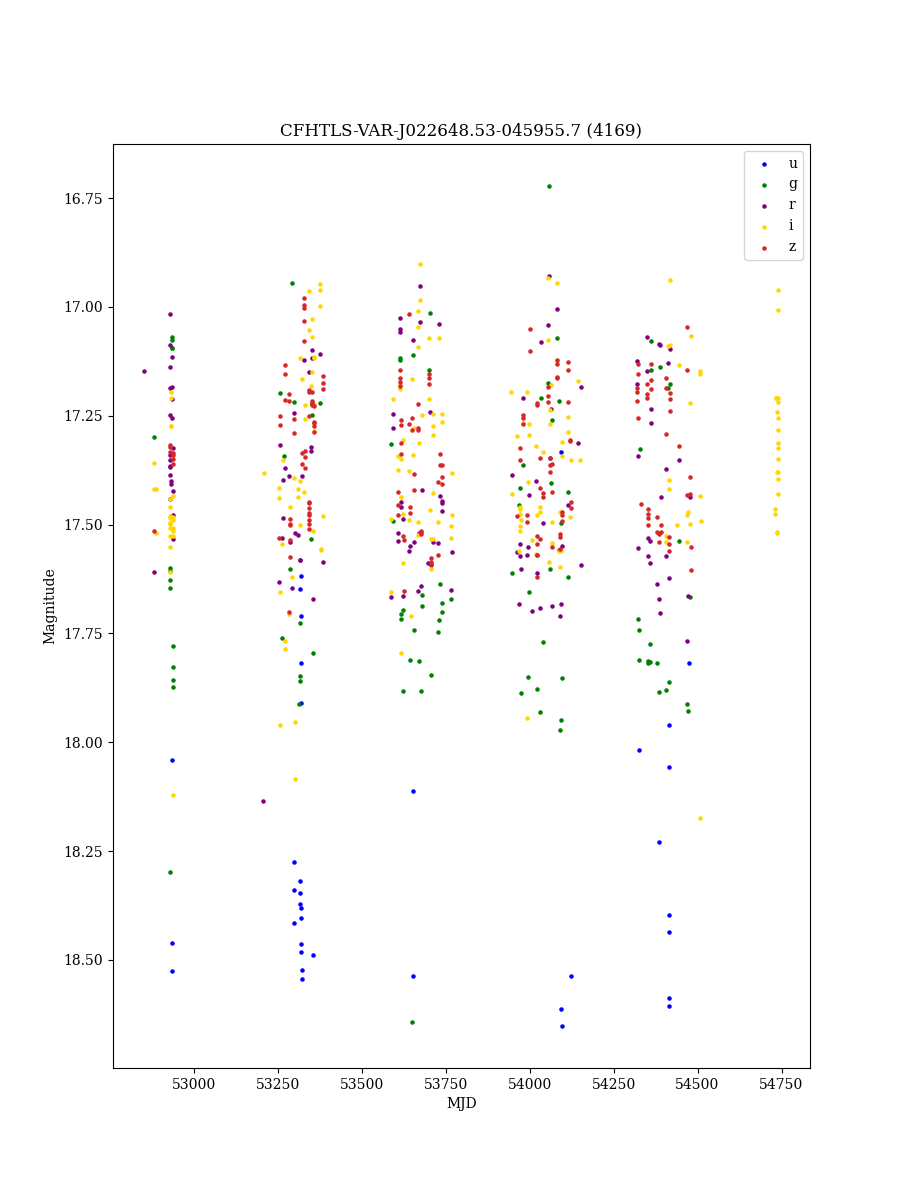

<IPython.core.display.Javascript object>


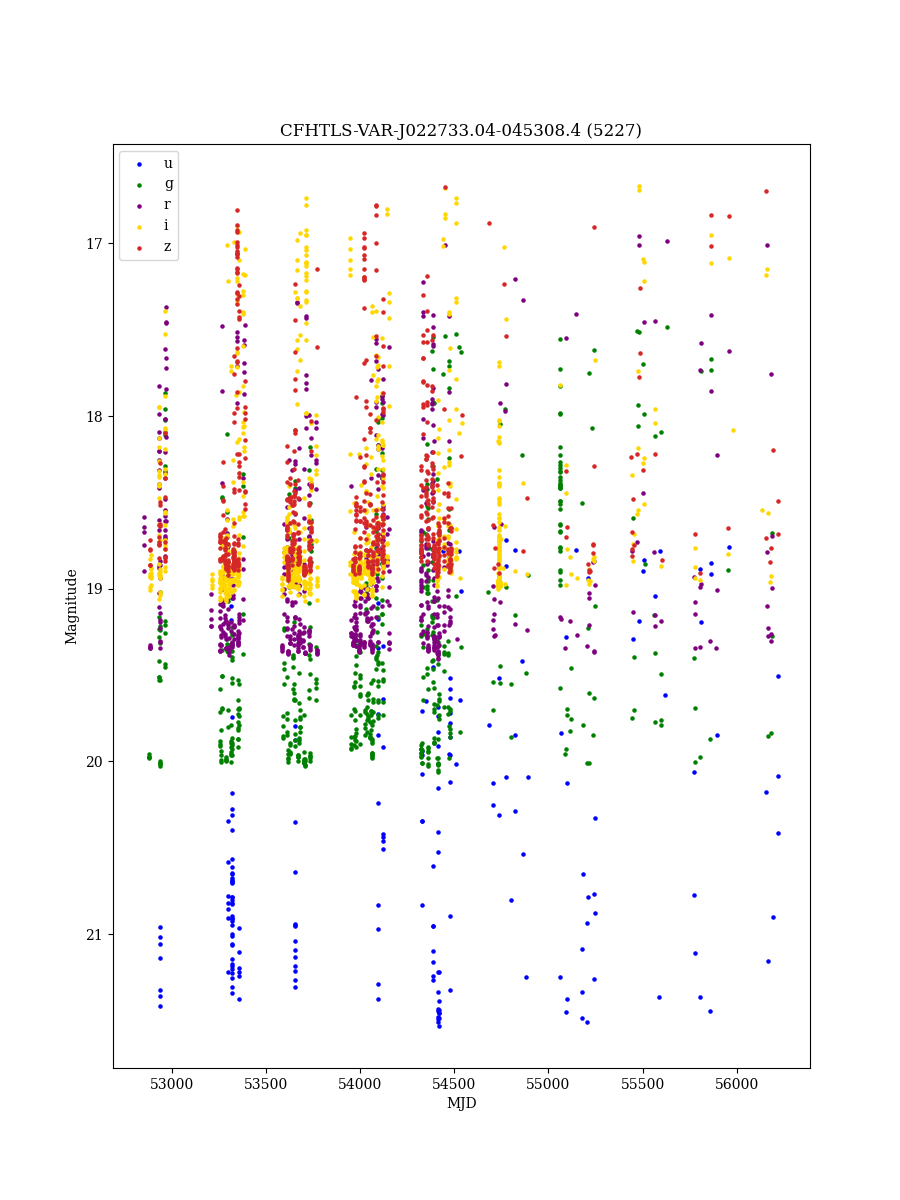

<IPython.core.display.Javascript object>


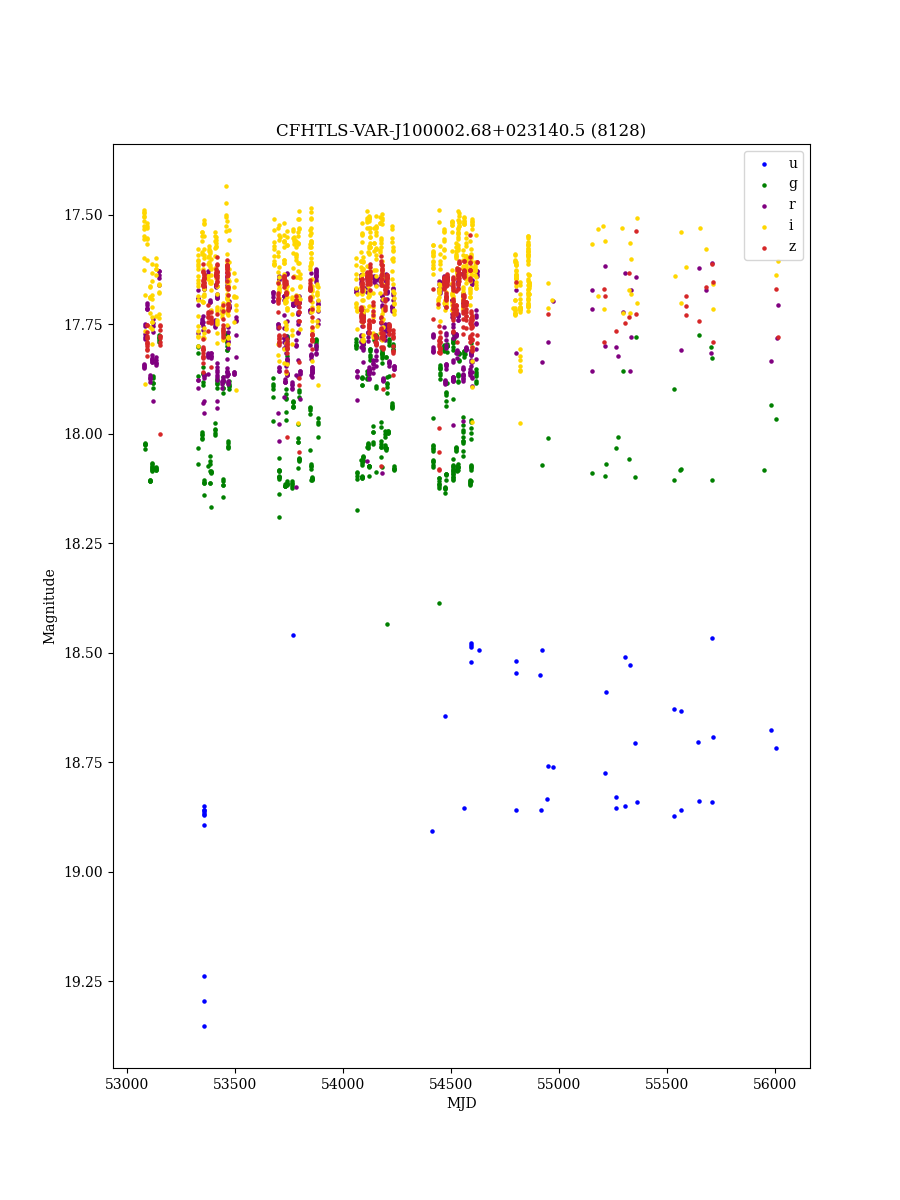

<IPython.core.display.Javascript object>


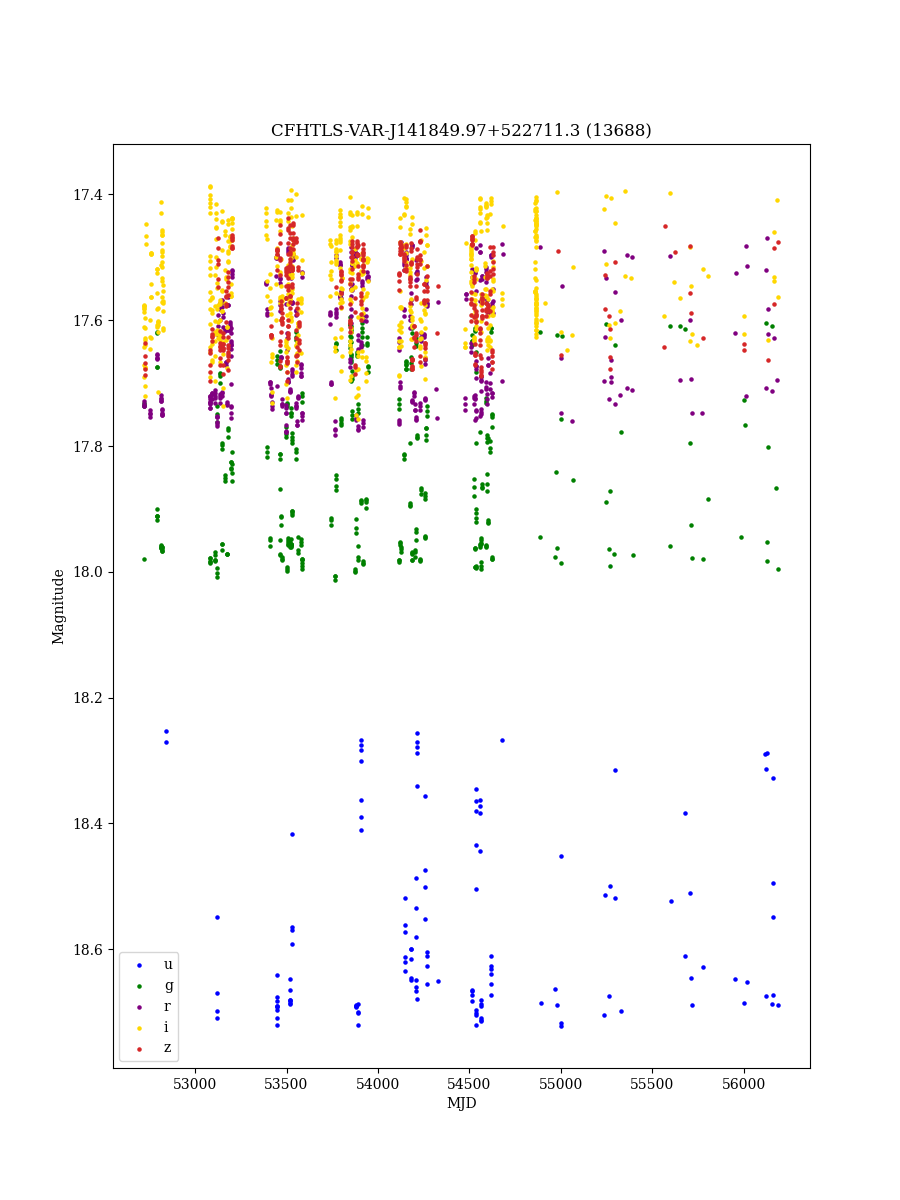

<IPython.core.display.Javascript object>


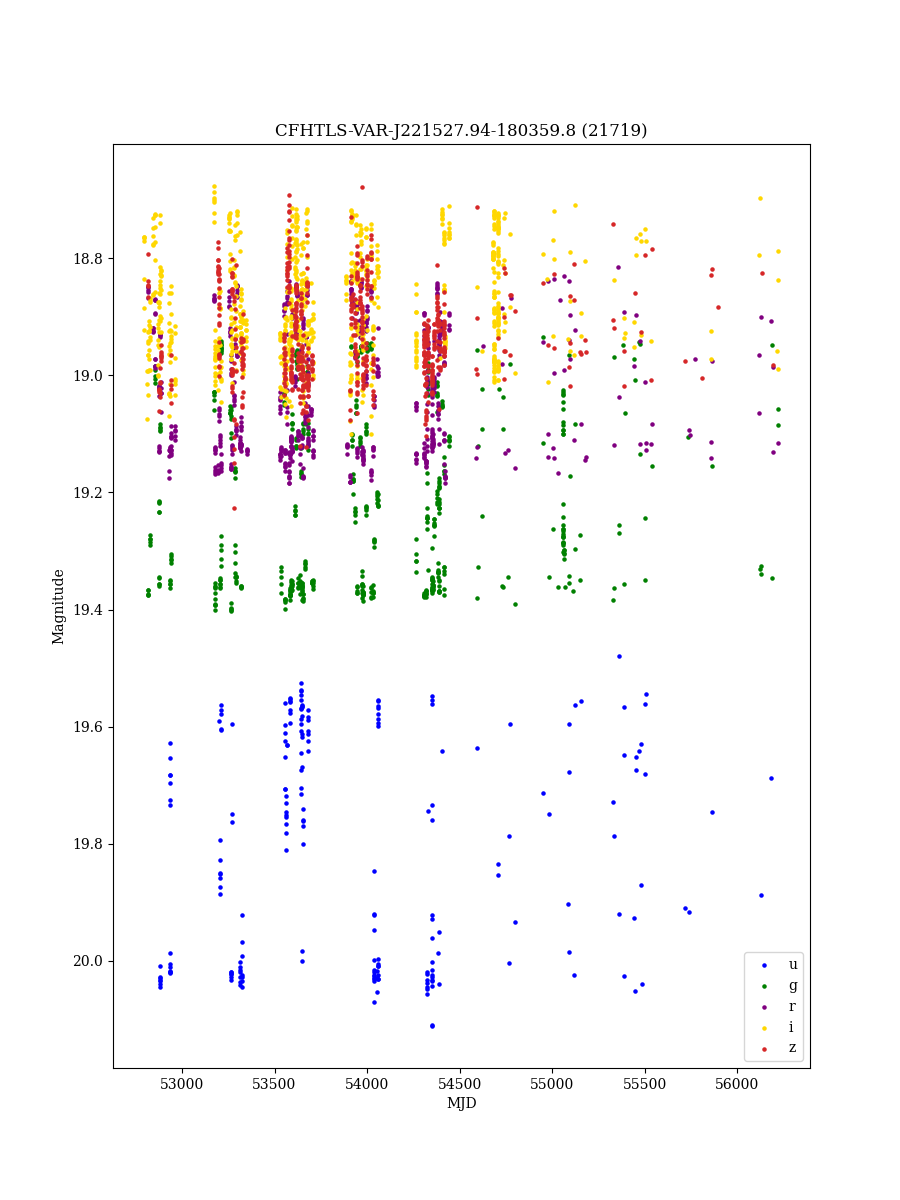

In [36]:
RRLyraeCandidates = ["CFHTLS-VAR-J022648.53-045955.7",
                     "CFHTLS-VAR-J022733.04-045308.4",
                     "CFHTLS-VAR-J100002.68+023140.5",
                     "CFHTLS-VAR-J141849.97+522711.3",
                     "CFHTLS-VAR-J221527.94-180359.8"]

RRLyraeCandidates_indices = []

for i in RRLyraeCandidates:
    RRLyraeCandidates_indices.append(fnames.index(i))
    
#print(RRLyraeCandidates_indices)
for i in RRLyraeCandidates_indices:
    plot_unfolded_light_curve(i, False)

In [37]:
def lomb_scargle_list (object_list, period_search = 'Course'):
    """
    Function that conducts Lomb Scargle analysis on a list of candidates
    ---
    object_list: list of object IDs 
    Returns
    ---
    best_period: array of the best period for each object
    best_period_index: array of the index in periods
    prints periodogram for each object
    """
    best_period = []
    best_period_index = []
    count = 0
    if(period_search == 'Fine'):
        num_bins = fine_period_search
    elif(period_search == 'Medium'):
        num_bins = medium_period_search
    else:
        num_bins = course_period_search
        
    for cur_object in object_list:
        t, mags, dy, filts = data_format(cur_object)
        periods = np.linspace(0.1, 1.0, num_bins)
        LS_multi = periodic.LombScargleMultiband(Nterms_base=1, Nterms_band=0)#initiate structure variable
        LS_multi.fit(t, mags, dy, filts)#input our data
        P_multi = LS_multi.periodogram(periods)#function where input is periods
        plt.ion() #turns figure display on
        plt.figure()
        plt.scatter(periods, P_multi, s = 0.05)
        best_period=max(P_multi)
        for i in range(len(P_multi)):
            if P_multi[i] == best_period:
                best_period_index.append(i)
        count = count +1
    return periods[best_period_index]

<IPython.core.display.Javascript object>


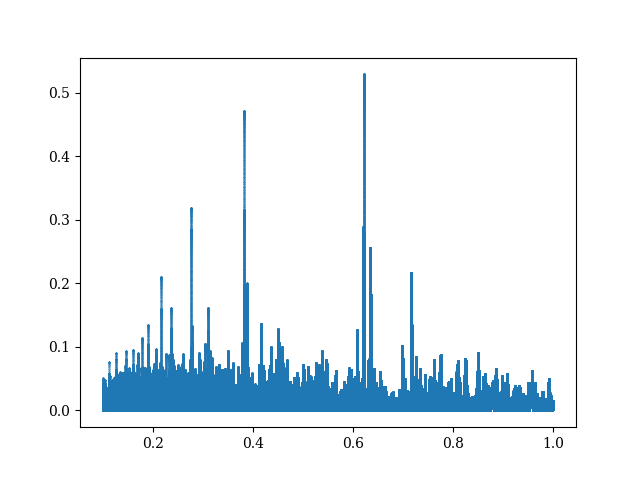

<IPython.core.display.Javascript object>


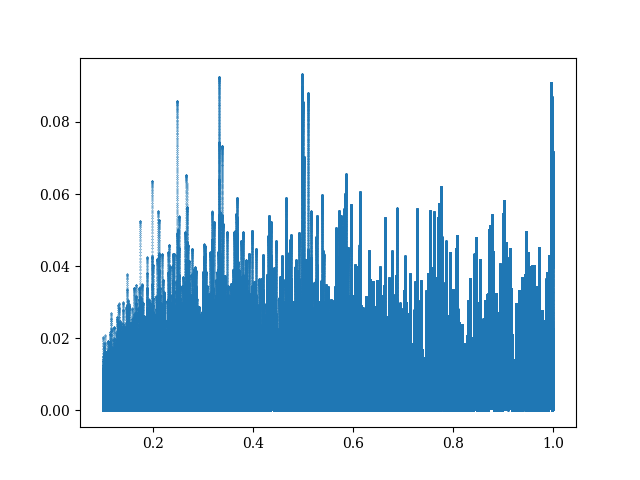

<IPython.core.display.Javascript object>


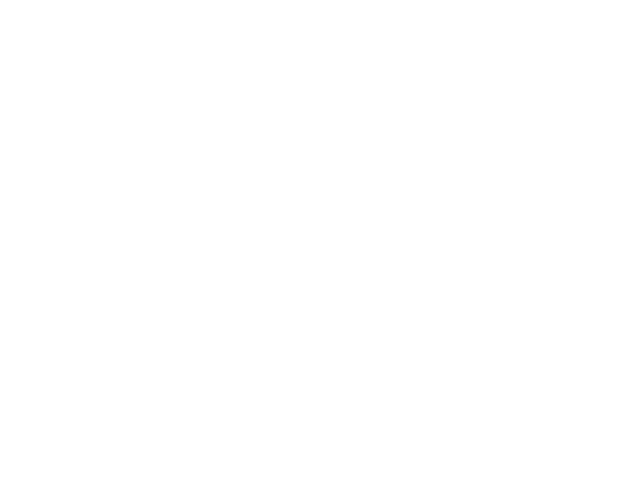

<IPython.core.display.Javascript object>


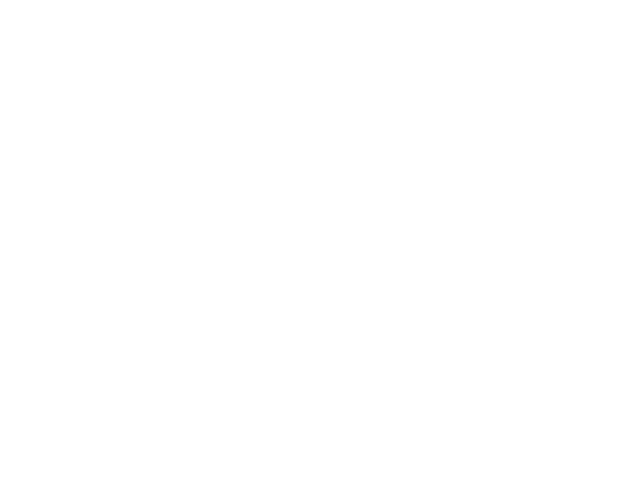

<IPython.core.display.Javascript object>


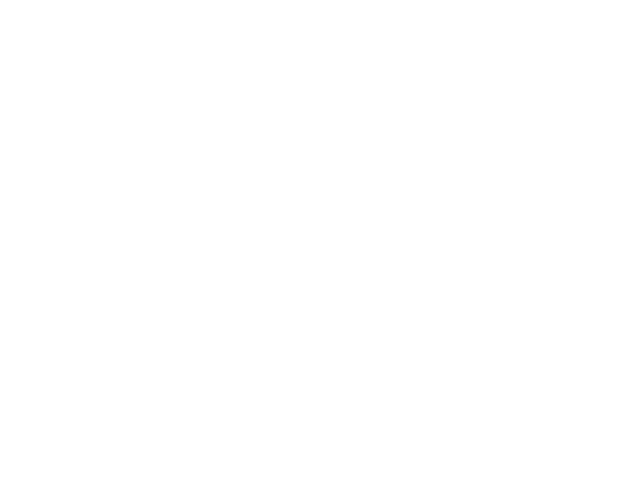

[0.62123942 0.4979754  0.64685793 0.65106453 0.82356612]


In [38]:
max_periods = lomb_scargle_list(RRLyraeCandidates_indices, 'Fine')
print(max_periods)

In [41]:
for i in range(len(RRLyraeCandidates)):
    #folded_light_curve(RRLyraeCandidates_indices[i], max_periods[i])
    #plot_combo_light_curve(RRLyraeCandidates_indices[i], max_periods[i])
    #pdf_combo_light_curve(RRLyraeCandidates_indices[i], max_periods[i], RRLyraeCandidates[i] + ".pdf")


IndentationError: expected an indented block (Temp/ipykernel_29288/1117030947.py, line 4)